In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
!curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   159  100   159    0     0    159      0  0:00:01  0:00:01 --:--:--   154

  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0 8863k    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
 10 8863k   10  887k    0     0   295k      0  0:00:29  0:00:03  0:00:26  447k
 25 8863k   25 2279k    0     0   569k      0  0:00:15  0:00:04  0:00:11  763k
 42 8863k   42 3783k    0     0   756k      0  0:00:11  0:00:05  0:00:06  949k
 62 8863k   62 5495k    0     0   915k      0  0:00:09  0:00:06  0:00:03 1102k
 82 8863k   82 7287k    0     0  1041k      0  0:00:08  0:00:07  0:00:01 1514k
100 8863k  100 8863k    0     0  1107k      0  0:0

In [6]:
data_dir = Path("./captcha_images_v2/")
images = sorted(list(map(str,list(data_dir.glob("*.png")))))

In [8]:
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)


Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  {'x', '5', 'b', '2', '8', 'd', '4', 'e', 'p', 'w', 'c', '6', '7', 'n', 'y', 'f', 'm', 'g', '3'}


In [9]:
batch_size = 16 
img_width = 200 
img_height = 50
downsample_factor = 4
max_length = max([len(label) for label in labels])

In [10]:
char_to_num = layers.experimental.preprocessing.StringLookup(
vocabulary = list(characters),
    num_oov_indices = 0,
    mask_token = None
)

In [11]:
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary = char_to_num.get_vocabulary(),
    mask_token = None,
    invert = True
)

In [12]:
def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid

In [13]:
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


In [14]:
def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

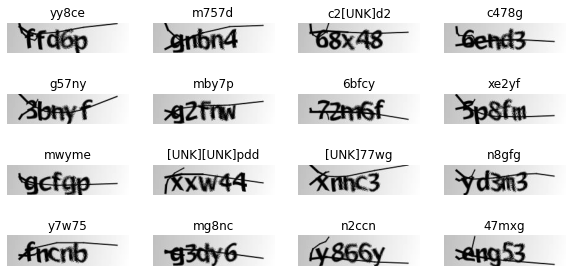

In [16]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [17]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(len(characters) + 1, activation="softmax", name="dense2")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()


Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]']       

Epoch 1/100
59/59 [==============================] - 32s 184ms/step - loss: 20.5575 - val_loss: 16.3520
Epoch 2/100
59/59 [==============================] - 5s 84ms/step - loss: 16.3345 - val_loss: 16.3387
Epoch 3/100
59/59 [==============================] - 5s 85ms/step - loss: 16.3356 - val_loss: 16.3389
Epoch 4/100
59/59 [==============================] - 5s 79ms/step - loss: 16.3387 - val_loss: 16.3385
Epoch 5/100
59/59 [==============================] - 5s 78ms/step - loss: 16.3338 - val_loss: 16.3366
Epoch 6/100
59/59 [==============================] - 5s 82ms/step - loss: 16.3298 - val_loss: 16.3313
Epoch 7/100
59/59 [==============================] - 5s 79ms/step - loss: 16.3252 - val_loss: 16.3320
Epoch 8/100
59/59 [==============================] - 5s 79ms/step - loss: 16.3169 - val_loss: 16.3287
Epoch 9/100
59/59 [==============================] - 5s 80ms/step - loss: 16.2948 - val_loss: 16.2678
Epoch 10/100
59/59 [==============================] - 5s 79ms/step - loss: 16.14

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            49216 

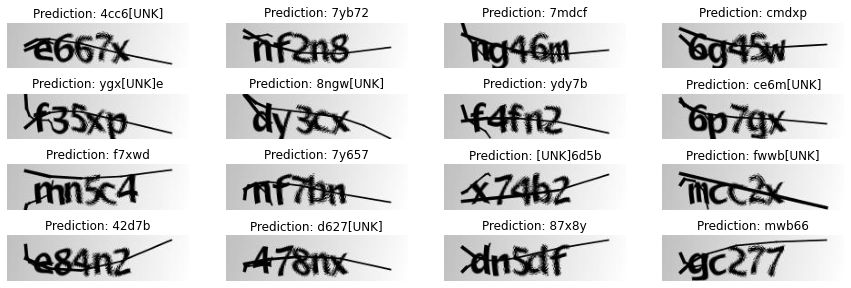

In [ ]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()